In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import utils4

## Reading in files and indexing them on time

In [112]:
targets_a = pd.read_parquet('../data/A/train_targets.parquet')
targets_b = pd.read_parquet('../data/B/train_targets.parquet')
targets_c = pd.read_parquet('../data/C/train_targets.parquet')
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index("time")
targets_c = targets_c.set_index("time")


In [113]:
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [114]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [115]:
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


## Some EDA

In [116]:
# Notice that missing rows are simply non-existent for Y_train_a, not filled with NaN or anything
# From 21. october
display(targets_a[29660:29670])

,pv_measurement
time,
2022-10-20 18:00:00,0.0
2022-10-20 19:00:00,0.0
2022-10-20 20:00:00,0.0
2022-10-20 21:00:00,0.0
2022-10-20 22:00:00,0.0
2022-10-20 23:00:00,0.0
2022-10-21 00:00:00,0.0
2022-10-28 22:00:00,0.0
2022-10-28 23:00:00,0.0


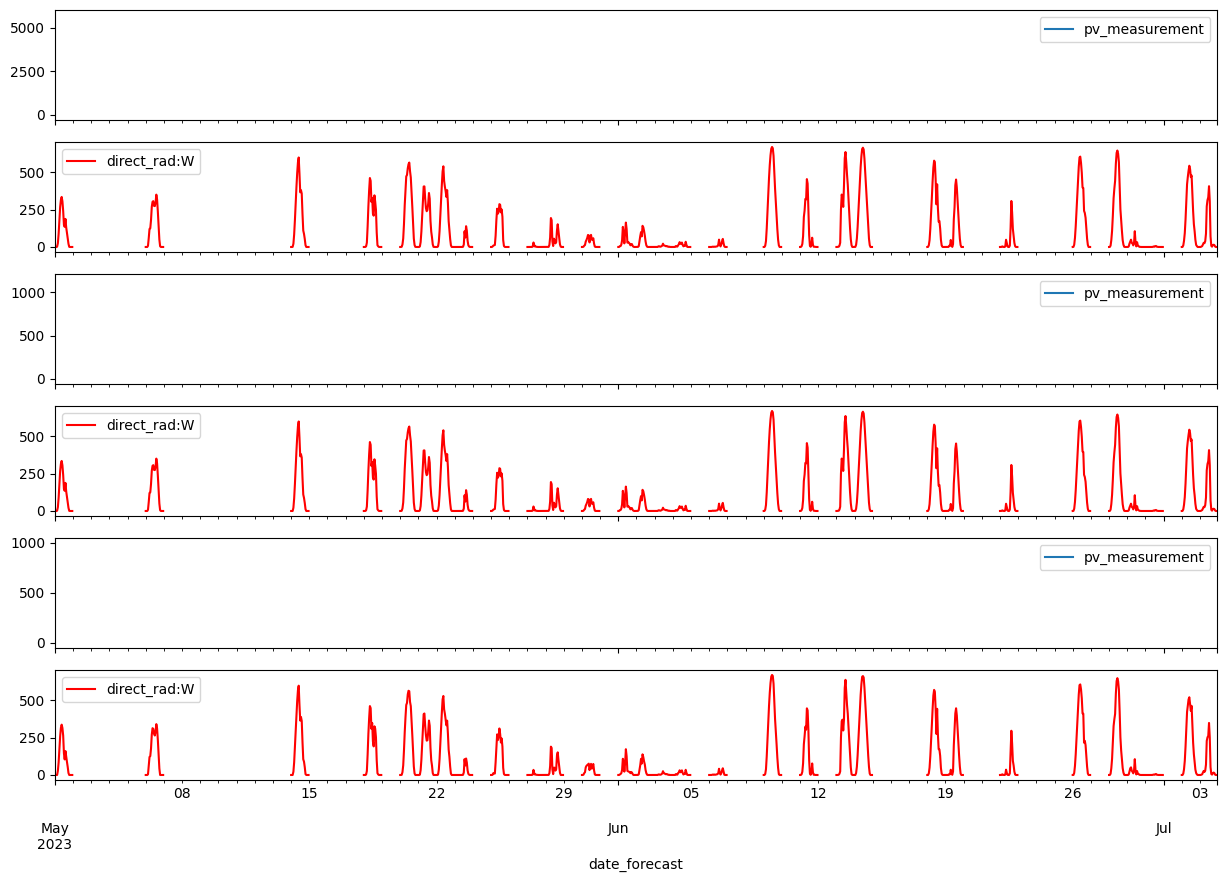

In [117]:
### generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad:W"

Y = [targets_a, targets_b, targets_c]
X = [X_test_estimated_a, X_test_estimated_b, X_test_estimated_c, ]

utils4.plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

## Data Preprocessing

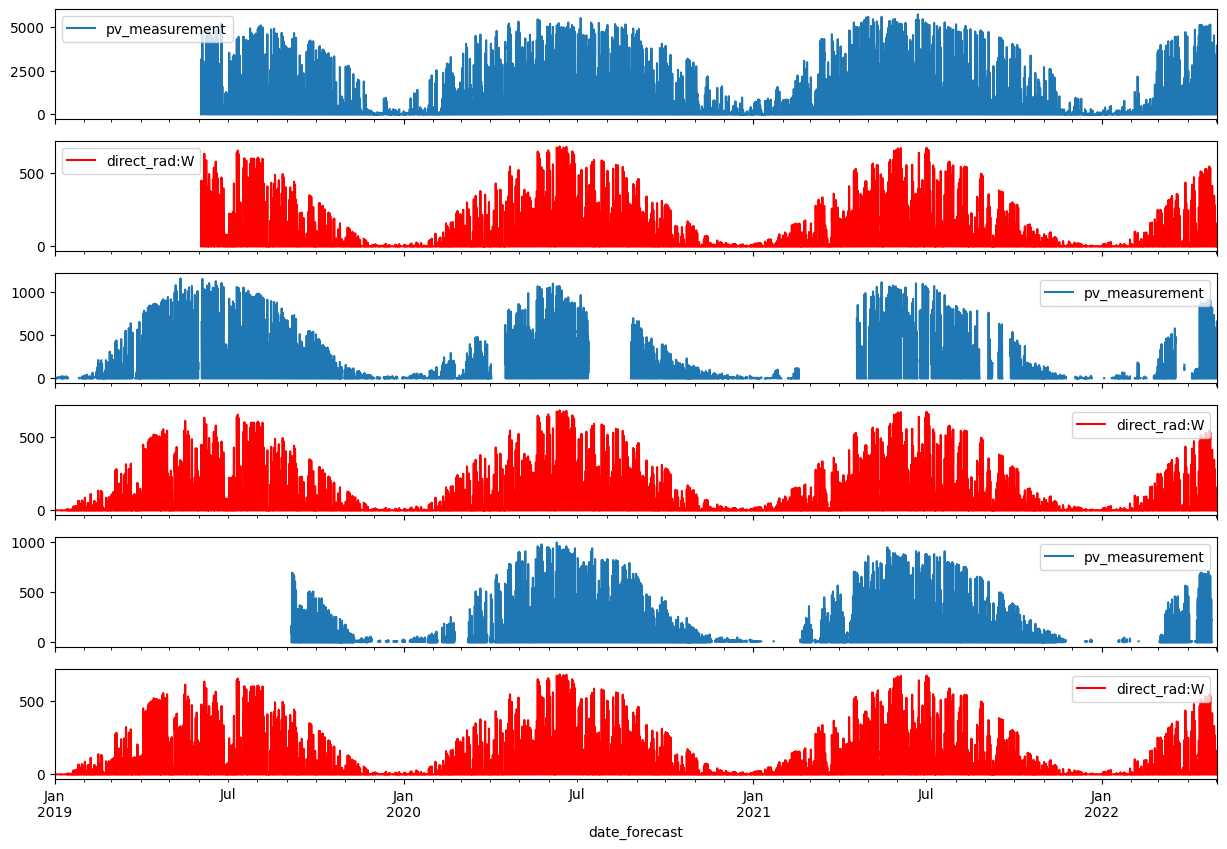

In [118]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_a = utils4.remove_constant_values(targets_a, "pv_measurement", 18).dropna()
targets_b = utils4.remove_constant_values(targets_b, "pv_measurement", 18).dropna()
targets_c = utils4.remove_constant_values(targets_c, "pv_measurement", 18).dropna()

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

start_date = '2019'
end_date = '2024'
feature_name = "direct_rad:W"

utils4.plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

In [119]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofyear'] = new_df.index.dayofyear
    # new_df = df.copy()
    # new_df['hour'] = new_df.index.hour
    # new_df['dayofweek'] = new_df.index.dayofweek
    # new_df['quarter'] = new_df.index.quarter
    # new_df['month'] = new_df.index.month
    # new_df['year'] = new_df.index.year
    # new_df['dayofyear'] = new_df.index.dayofyear
    # new_df['dayofmonth'] = new_df.index.day
    # new_df['weekofyear'] = new_df.index.isocalendar()[1]
    return new_df

In [120]:
### Adding more time based features to the datasets
X_train_observed_a = create_features(X_train_observed_a)
X_train_observed_b = create_features(X_train_observed_b)
X_train_observed_c = create_features(X_train_observed_c)

X_train_estimated_a = create_features(X_train_estimated_a)
X_train_estimated_b = create_features(X_train_estimated_b)
X_train_estimated_c = create_features(X_train_estimated_c)

X_test_estimated_a = create_features(X_test_estimated_a)
X_test_estimated_b = create_features(X_test_estimated_b)
X_test_estimated_c = create_features(X_test_estimated_c)

In [121]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)

In [122]:
def add_lag(df):
    new_df = df.copy()
    

In [123]:
# Check which features most correlated with y
correlations = train_a.corrwith(train_a["pv_measurement"])
for index, corr in correlations.items():
    correlations[index] = abs(corr)

sorted = correlations.sort_values(ascending=False)
best_features = list(sorted[1:10].index)
print(best_features)

['direct_rad:W', 'direct_rad_1h:J', 'clear_sky_rad:W', 'clear_sky_energy_1h:J', 'diffuse_rad:W', 'sun_elevation:d', 'diffuse_rad_1h:J', 'is_in_shadow:idx', 'is_day:idx']


## Create our model

### Select Features

In [124]:
FEATURES = list(train_a.columns[:-1]) # Using all the features of X.
TARGETS = "pv_measurement"

### DATA
X_a = train_a[FEATURES]
y_a = train_a[TARGETS]

X_b = train_b[FEATURES]
y_b = train_b[TARGETS]

X_c = train_c[FEATURES]
y_c = train_c[TARGETS]

### Location A

#### Hyperparameter tuning

In [125]:
from sklearn.model_selection import RandomizedSearchCV

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Define the hyperparameters and their possible values
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [100, 200, 500, 1000],
    'gamma': [0, 0.25, 0.5, 1.0],
    'min_child_weight': [1, 2, 3, 4]
}

# Initialize XGBRegressor
reg = xgb.XGBRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    reg, 
    param_distributions=param_dist, 
    n_iter=100, 
    scoring='neg_mean_absolute_error', 
    verbose=1, 
    cv=3, 
    n_jobs=-1
)

# Fit the model
# random_search.fit(X_train_a, y_train_a)
# random_search.fit(X_train_b, y_train_b)
# random_search.fit(X_train_c, y_train_c)

# Print the best parameters
# print(random_search.best_params_)



In [126]:
default_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'early_stopping_rounds': 100,
    'objective': 'reg:absoluteerror'
}

best_params_a = {'subsample': 0.9, 
               'n_estimators': 1000, 
               'min_child_weight': 3, 
               'max_depth': 8, 
               'learning_rate': 0.05, 
               'gamma': 0.25, 
               'colsample_bytree': 0.5,
               'objective': 'reg:absoluteerror',
               'early_stopping_rounds': 100}

best_params_bc = {'subsample': 0.7, 
                  'n_estimators': 1000,
                  'min_child_weight': 3, 
                  'max_depth': 7, 
                  'learning_rate': 0.05, 
                  'gamma': 0.5, 
                  'colsample_bytree': 0.5,
                  'objective': 'reg:absoluteerror',
                  'early_stopping_rounds': 100}

In [127]:
### Location A

### If using validation set, split the data into training and testing sets 
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_A = xgb.XGBRegressor(**best_params_a)

# Fit the model on the training data
reg_A.fit(X_train_a, y_train_a,
        eval_set = [(X_train_a, y_train_a), (X_test_a, y_test_a)],
        verbose=100)

# Make predictions on the test data
y_pred_a = reg_A.predict(X_test_a)

y_pred_a = np.clip(y_pred_a, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_a, y_pred_a)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:691.18026	validation_1-mae:694.46843
[100]	validation_0-mae:184.23266	validation_1-mae:210.85973
[200]	validation_0-mae:173.93171	validation_1-mae:207.34907
[300]	validation_0-mae:168.56624	validation_1-mae:206.19703
[400]	validation_0-mae:163.06368	validation_1-mae:205.33525
[500]	validation_0-mae:156.52283	validation_1-mae:204.63202
[600]	validation_0-mae:152.35372	validation_1-mae:204.15823
[700]	validation_0-mae:148.19582	validation_1-mae:203.81983
[800]	validation_0-mae:142.03671	validation_1-mae:202.99751
[900]	validation_0-mae:136.05966	validation_1-mae:202.22997
[999]	validation_0-mae:133.70460	validation_1-mae:202.00429
Mean Absolute Error: 201.54063992318936


### Location B

In [128]:
### Location B

# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_B = xgb.XGBRegressor(**best_params_bc)

# Fit the model on the training data
reg_B.fit(X_train_b, y_train_b,
        eval_set = [(X_train_b, y_train_b), (X_test_b, y_test_b)],
        verbose=100)

# Make predictions on the test data
y_pred_b = reg_B.predict(X_test_b)

y_pred_b = np.clip(y_pred_b, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_b, y_pred_b)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:131.28248	validation_1-mae:129.27055
[100]	validation_0-mae:30.37621	validation_1-mae:35.67072
[200]	validation_0-mae:28.32416	validation_1-mae:34.75786
[300]	validation_0-mae:27.21968	validation_1-mae:34.44691
[400]	validation_0-mae:26.09232	validation_1-mae:34.15975
[500]	validation_0-mae:25.10999	validation_1-mae:33.87430
[600]	validation_0-mae:24.10921	validation_1-mae:33.70397
[700]	validation_0-mae:23.20304	validation_1-mae:33.58432
[800]	validation_0-mae:22.29328	validation_1-mae:33.43995
[900]	validation_0-mae:21.40822	validation_1-mae:33.33247
[999]	validation_0-mae:20.69087	validation_1-mae:33.28207
Mean Absolute Error: 33.15063747760344


### Location C

In [129]:
### Location C

# Split the data into training and testing sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_C = xgb.XGBRegressor(**best_params_bc)

# Fit the model on the training data
reg_C.fit(X_train_c, y_train_c,
        eval_set = [(X_train_c, y_train_c), (X_test_c, y_test_c)],
        verbose=100)

# Make predictions on the test data
y_pred_c = reg_C.predict(X_test_c)

y_pred_c = np.clip(y_pred_c, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_c, y_pred_c)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:114.11847	validation_1-mae:108.34757
[100]	validation_0-mae:25.63153	validation_1-mae:30.18555
[200]	validation_0-mae:23.65011	validation_1-mae:29.45384
[300]	validation_0-mae:22.37874	validation_1-mae:29.14685
[400]	validation_0-mae:21.51472	validation_1-mae:29.03470
[500]	validation_0-mae:20.67411	validation_1-mae:28.88831
[600]	validation_0-mae:19.73329	validation_1-mae:28.74920
[700]	validation_0-mae:18.96885	validation_1-mae:28.59429
[800]	validation_0-mae:18.38708	validation_1-mae:28.49709
[900]	validation_0-mae:17.83395	validation_1-mae:28.41834
[999]	validation_0-mae:17.28192	validation_1-mae:28.28645
Mean Absolute Error: 28.186321299691958


## Analysis

### Feature Importance

In [130]:
fi_a = pd.DataFrame(data=reg_A.feature_importances_,
             index=reg_A.feature_names_in_,
             columns=["importance"])
fi_a.sort_values("importance", ascending=False).head()

,importance
is_in_shadow:idx,0.453117
is_day:idx,0.362881
diffuse_rad:W,0.040898
sun_elevation:d,0.035478
clear_sky_rad:W,0.017791


In [131]:
fi_b = pd.DataFrame(data=reg_B.feature_importances_,
             index=reg_B.feature_names_in_,
             columns=["importance"])
fi_b.sort_values("importance", ascending=False).head()

,importance
is_in_shadow:idx,0.446849
is_day:idx,0.267606
sun_elevation:d,0.062466
diffuse_rad:W,0.041979
clear_sky_rad:W,0.030727


In [132]:
fi_c = pd.DataFrame(data=reg_C.feature_importances_,
             index=reg_C.feature_names_in_,
             columns=["importance"])
fi_c.sort_values("importance", ascending=False).head()

,importance
is_day:idx,0.398771
is_in_shadow:idx,0.321672
sun_elevation:d,0.054520
diffuse_rad:W,0.043219
clear_sky_rad:W,0.027163


### Visualizing the validation sets

<Axes: >

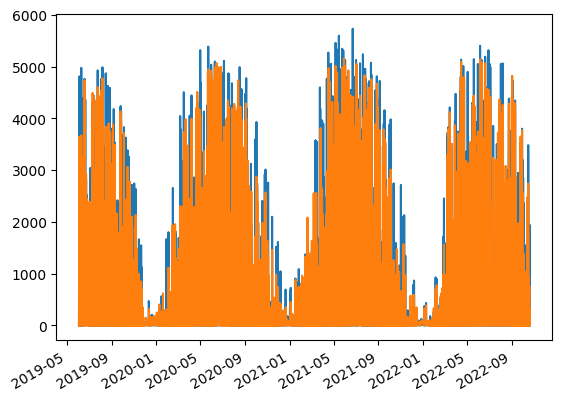

In [133]:
y_test_a.plot()
X_test_a["prediction"] = y_pred_a
X_test_a["prediction"].plot()

<Axes: >

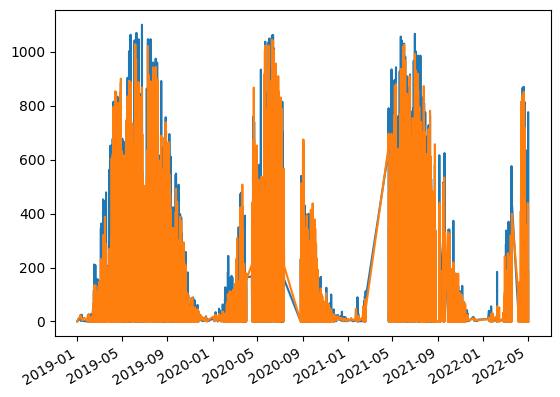

In [134]:
y_test_b.plot()
X_test_b["prediction"] = y_pred_b
X_test_b["prediction"].plot()

<Axes: >

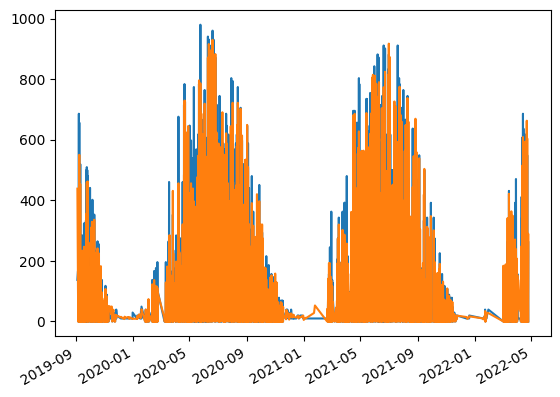

In [135]:
y_test_c.plot()
X_test_c["prediction"] = y_pred_c
X_test_c["prediction"].plot()

### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-28 11:00:00    3579.865352
2023-04-28 12:00:00    3081.865137
2023-04-28 10:00:00    2961.318574
2023-04-16 08:00:00    2541.388125
2023-03-23 13:00:00    2487.883330
Name: error, dtype: float64

Mean Absolute Error: 132.87122703792735
MAE for the last 1000 values: 267.6816104583398


<Axes: >

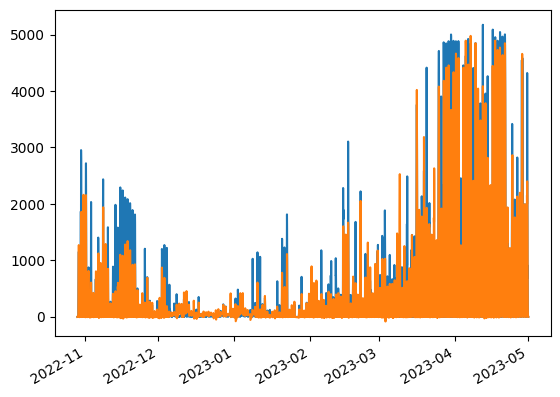

In [136]:
df = X_train_estimated_a[FEATURES]
df["prediction"] = reg_A.predict(X_train_estimated_a[FEATURES])

df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

2023-04-28 11:00:00    654.459679
2023-04-28 12:00:00    530.126902
2023-04-30 12:00:00    477.058793
2023-04-08 11:00:00    474.579087
2023-04-28 10:00:00    460.001650
Name: error, dtype: float64

Mean Absolute Error: 19.109611182694472
MAE for the last 1000 values: 37.77245540032505


<Axes: >

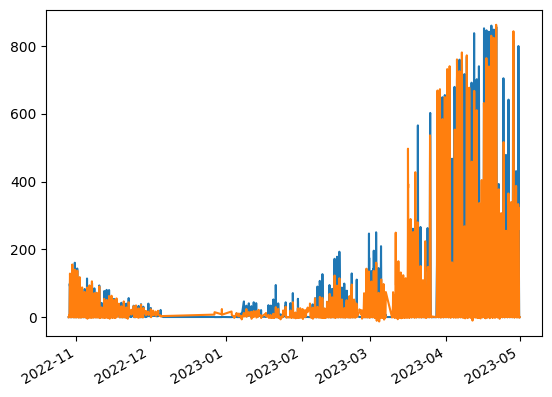

In [137]:
df = X_train_estimated_b[FEATURES]
df["prediction"] = reg_B.predict(X_train_estimated_b[FEATURES])

df = pd.merge(df, targets_b, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

print(f"Mean Absolute Error: {mae}")

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()

2023-03-27 11:00:00    452.863151
2023-03-27 12:00:00    446.228165
2023-03-27 10:00:00    406.954962
2023-03-27 13:00:00    397.077719
2023-04-28 11:00:00    334.954629
Name: error, dtype: float64

Mean Absolute Error: 26.803475923215483
MAE for the last 1000 values: 48.90410036848871


<Axes: >

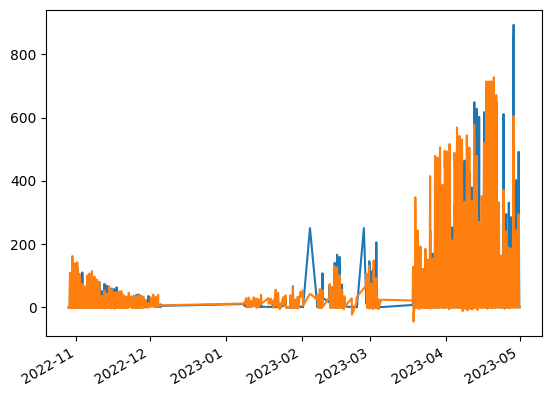

In [138]:
df = X_train_estimated_c[FEATURES]
df["prediction"] = reg_C.predict(X_train_estimated_c[FEATURES])

df = pd.merge(df, targets_c, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])
print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()


## Predicting on the actual test set

In [139]:
### Location B
X_test_estimated_a = X_test_estimated_a[FEATURES]
A_pred = reg_A.predict(X_test_estimated_a)
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])
    

In [140]:
### Location B
X_test_estimated_b = X_test_estimated_b[FEATURES]
B_pred = reg_B.predict(X_test_estimated_b)
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

In [141]:
   
### Location C
X_test_estimated_c = X_test_estimated_c[FEATURES]
C_pred = reg_C.predict(X_test_estimated_c)
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

### Visualizing how the model predicts on the actual test set

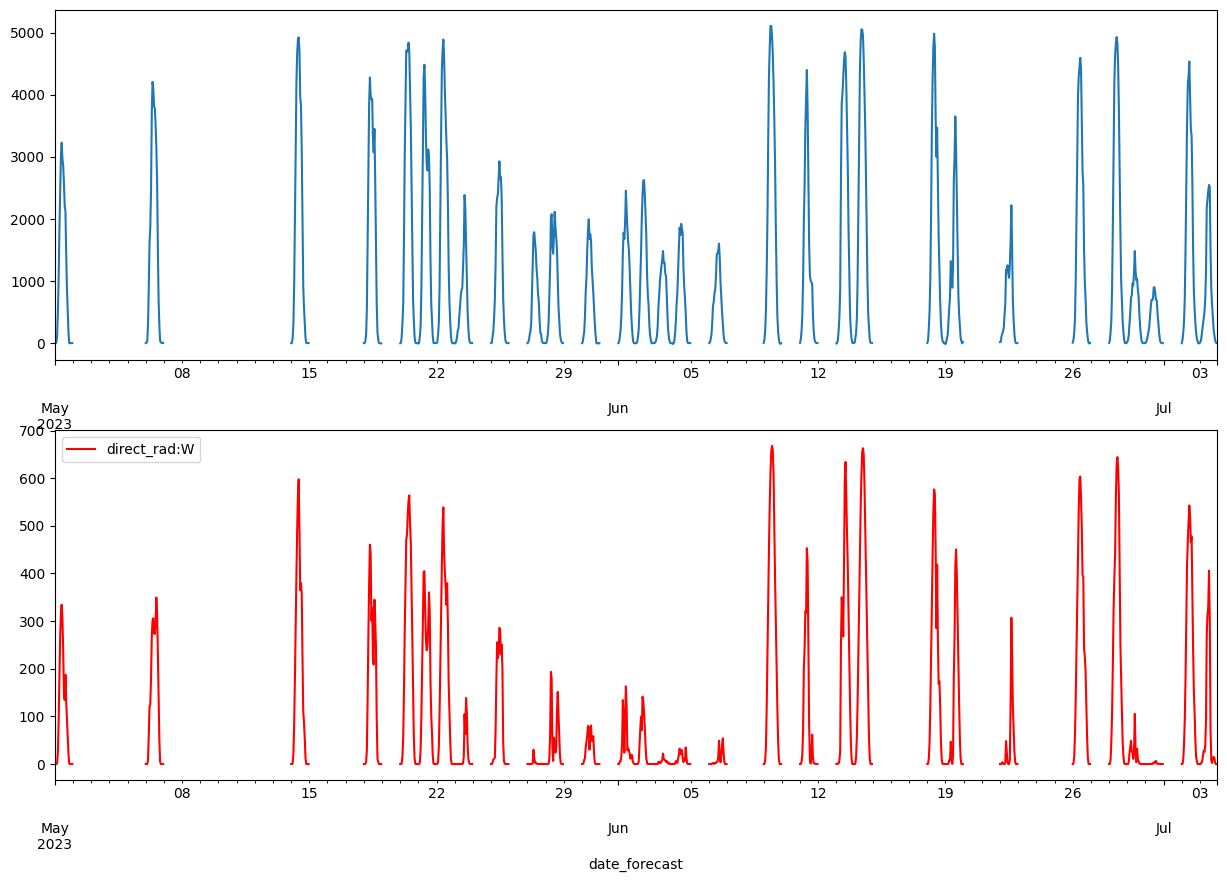

In [142]:
df = X_test_estimated_a.copy()
df["prediction"] = reg_A.predict(X_test_estimated_a[FEATURES])

start = "05-2023"
end = "08-2023"
feature = "direct_rad:W"

utils4.plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)



## Storing the predictions

In [143]:
predictions = np.concatenate([A_pred_hourly, B_pred_hourly, C_pred_hourly])
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
df.to_csv("saves/xgboost4.csv", index=False)